# NovaPay Feature Engineering

###  Using Nova_cleanedEDA_df.csv to explore and compute feature engineering.



In [273]:
# Import liraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [275]:
df = pd.read_csv("../data/Nova_CleanedEDA_df.csv")

# To check the number of rows and columns
print("\n📌 Dataset Shape:", df.shape)

# Print the top 5 rows
df.head()


📌 Dataset Shape: (11137, 26)


,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.123,STANDARD,263,0.522,0,0.223,0,0,0.0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,WEB,208.51,154.29,4.24,...,0.569,STANDARD,947,0.475,0,0.268,0,1,0.0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,MOBILE,160.33,160.33,2.70,...,0.437,ENHANCED,367,0.939,0,0.176,0,0,0.0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,MOBILE,59.41,59.41,2.22,...,0.594,STANDARD,147,0.551,0,0.391,0,0,0.0,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,MOBILE,200.96,200.96,3.61,...,0.121,ENHANCED,257,0.894,0,0.257,0,0,0.0,0


## Dataset Overview

#### Basic information about data types & missing values

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11137 entries, 0 to 11136
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11137 non-null  object 
 1   customer_id                11137 non-null  object 
 2   timestamp                  11137 non-null  object 
 3   home_country               11137 non-null  object 
 4   source_currency            11137 non-null  object 
 5   dest_currency              11137 non-null  object 
 6   channel                    11137 non-null  object 
 7   amount_src                 11137 non-null  float64
 8   amount_usd                 11137 non-null  float64
 9   fee                        11137 non-null  float64
 10  exchange_rate_src_to_dest  11137 non-null  float64
 11  device_id                  11137 non-null  object 
 12  new_device                 11137 non-null  int64  
 13  ip_address                 11137 non-null  obj

In [278]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [279]:
# Extract time-based features

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek # 0=Mon, 6=Sun
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_night'] = df['hour'].between(2, 8).astype(int)

print("Time features created:")
print(df[['timestamp', 'hour', 'day_of_week', 'is_weekend', 'is_night']].head())
print("\nTransaction Hour Distribution:")
print(df['hour'].value_counts().sort_index())

Time features created:
                         timestamp  hour  day_of_week  is_weekend  is_night
0 2022-10-03 18:40:59.468549+00:00    18            0           0         0
1 2022-10-03 20:39:38.468549+00:00    20            0           0         0
2 2022-10-03 23:02:43.468549+00:00    23            0           0         0
3 2022-10-04 01:08:53.468549+00:00     1            1           0         0
4 2022-10-04 09:35:03.468549+00:00     9            1           0         0

Transaction Hour Distribution:
hour
0     465
1     414
2     421
3     495
4     509
5     487
6     477
7     460
8     485
9     438
10    469
11    441
12    460
13    468
14    436
15    480
16    464
17    439
18    481
19    508
20    456
21    435
22    456
23    493
Name: count, dtype: int64


In [280]:
#  Extract time of day

def time_of_day(h):
    if h < 6: return "late_night"
    if h < 12: return "morning"
    if h < 18: return "afternoon"
    return "evening"

df["time_of_day"] = df["hour"].apply(time_of_day)

In [281]:
# Currency Path Feature

df["currency_pair"] = df["source_currency"] + "_" + df["dest_currency"]

In [282]:
# High risk device score

df['High risk device'] = df['new_device'].astype(int) * (1 - df['device_trust_score'])

In [283]:
# IP usage count

df["ip_usage_count"] = df.groupby("ip_address")["transaction_id"].transform("count")

In [284]:
# Compute velocity ratio

df["velocity_ratio"] = df["txn_velocity_1h"] / (df["txn_velocity_24h"] + 1)

In [285]:
# Compute fee ratio
df["fee_ratio"] = df["fee"] / df["amount_usd"]

In [286]:
df['amount_velocity_interaction'] = df['amount_usd'] * df['velocity_ratio']
df['device_ip_risk'] = df['device_trust_score'] * df['ip_risk_score']
df['new_device_velocity'] = df['new_device'] * df['txn_velocity_1h']


In [328]:
df['new_device_high_velocity'] = (
    (df['new_device'] == 1) &
    (df['txn_velocity_1h'] >= 3)
).astype(int)


In [330]:
df['young_account_high_amount'] = (
    (df['account_age_days'] < 30) &
    (df['amount_usd'] > 500)
).astype(int)


In [335]:
df['ip_location_risk'] = (
    (df['ip_risk_score'] > 0.7) &
    (df['location_mismatch'] == 1)
).astype(int)


### Examine Outliers

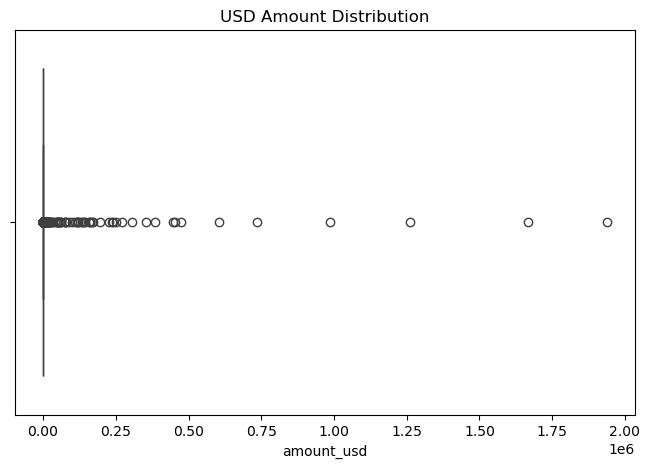

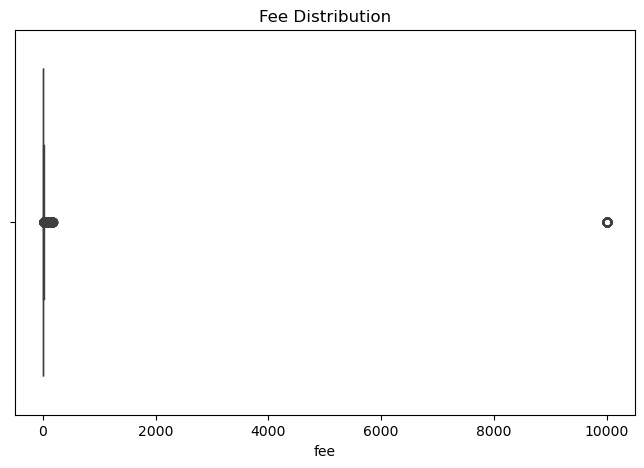

In [288]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="amount_usd")
plt.title("USD Amount Distribution")

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="fee")
plt.title("Fee Distribution")


plt.show()

## **Handling Outliers**

#### Check for outliers in numerical columns

#### 1. Capping (Winsorization) : Limiting very large (or very small) values to a fixed threshold instead of removing them.

##### In fraud data:
    - Extreme values often indicate fraud
    - Removing them would remove important signals
    - But leaving them unbounded can:
        * Break scale-sensitive models
        * Dominate learning
        * Cause unstable training

👉 Capping keeps the record but controls its influence.

#### 2. Log transform AFTER capping

##### Why?
    - scale-sensitive models assume smoother, less-skewed distributions
    - Extreme values (even capped ones) can dominate learning


In [290]:
# Capping 
df['amount_usd_capped'] = df['amount_usd'].clip(
    upper=df['amount_usd'].quantile(0.99)
)


# Log transform - reduces skewness
df['log_amount_usd'] = np.log1p(df['amount_usd_capped'].clip(lower=0))
df['log_fee'] = np.log1p(df['fee'].clip(lower=0))

***Insight:*** Extreme transaction amounts were capped at the 99th percentile to limit the influence of outliers, and log transformations were applied to reduce skewness for scale-sensitive models.

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11137 entries, 0 to 11136
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   transaction_id               11137 non-null  object             
 1   customer_id                  11137 non-null  object             
 2   timestamp                    11137 non-null  datetime64[ns, UTC]
 3   home_country                 11137 non-null  object             
 4   source_currency              11137 non-null  object             
 5   dest_currency                11137 non-null  object             
 6   channel                      11137 non-null  object             
 7   amount_src                   11137 non-null  float64            
 8   amount_usd                   11137 non-null  float64            
 9   fee                          11137 non-null  float64            
 10  exchange_rate_src_to_dest    11137 non-null  f

### Save data

In [339]:
df_features = df.copy()

df_features.to_csv(r"C:\Users\pehlu\OneDrive\projects\Nova\Data\Nova_Features_Eng.csv", index=False)